In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import models,optimizers,layers
import numpy as np

%matplotlib inline

## Dataset loading

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_name="20240412_1"
train_ds=tf.data.Dataset.load(f"datasets/{dataset_name}_train")
val_ds=tf.data.Dataset.load(f"datasets/{dataset_name}_val")
x=train_ds
class_names = ["Artifact","Meteor"]
# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



### Dataset visualization

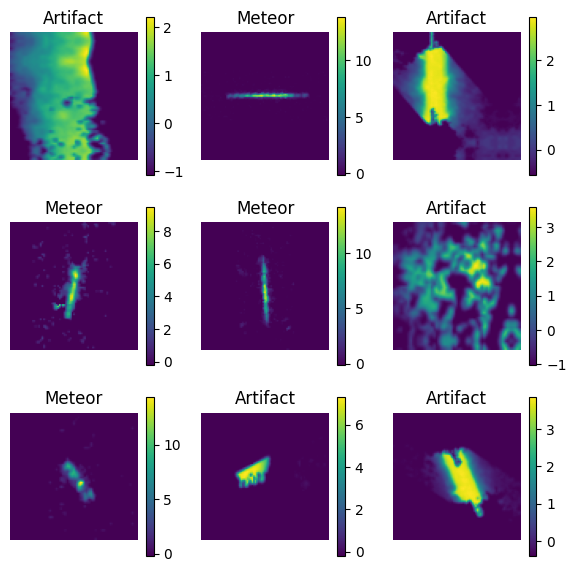

In [23]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

In [24]:
BATCH_SIZE = 32
IMAGE_SIZE=81

## Model

In [25]:
model_name= "CNN_20240412_1"
with open(f'models/{model_name}_config.json', 'r') as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)

In [26]:
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(),
    metrics=[
        tf.keras.metrics.F1Score(name="f1",threshold=0.5,average="micro"),
    ],
)

In [27]:
train_iteration=1

model.save(f"models/{model_name}_untrained_{train_iteration}.keras")

### Training model

In [28]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/10


36/36 [==============================] - 1s 15ms/step - loss: 0.2382 - f1: 0.9118 - val_loss: 0.1068 - val_f1: 0.9666
Epoch 2/10
36/36 [==============================] - 0s 7ms/step - loss: 0.1081 - f1: 0.9611 - val_loss: 0.1235 - val_f1: 0.9586
Epoch 3/10
36/36 [==============================] - 0s 7ms/step - loss: 0.0856 - f1: 0.9680 - val_loss: 0.1079 - val_f1: 0.9651
Epoch 4/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0719 - f1: 0.9741 - val_loss: 0.1116 - val_f1: 0.9622
Epoch 5/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0557 - f1: 0.9808 - val_loss: 0.1210 - val_f1: 0.9667
Epoch 6/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0428 - f1: 0.9887 - val_loss: 0.1213 - val_f1: 0.9612
Epoch 7/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0441 - f1: 0.9878 - val_loss: 0.1126 - val_f1: 0.9706
Epoch 8/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0257 - f1: 0.9965 - val_loss: 0.1049 - v

In [29]:
model.save(f"models/{model_name}_trained_{train_iteration}.keras")

### Result analysis

Validation F1-Score: 0.9669902324676514


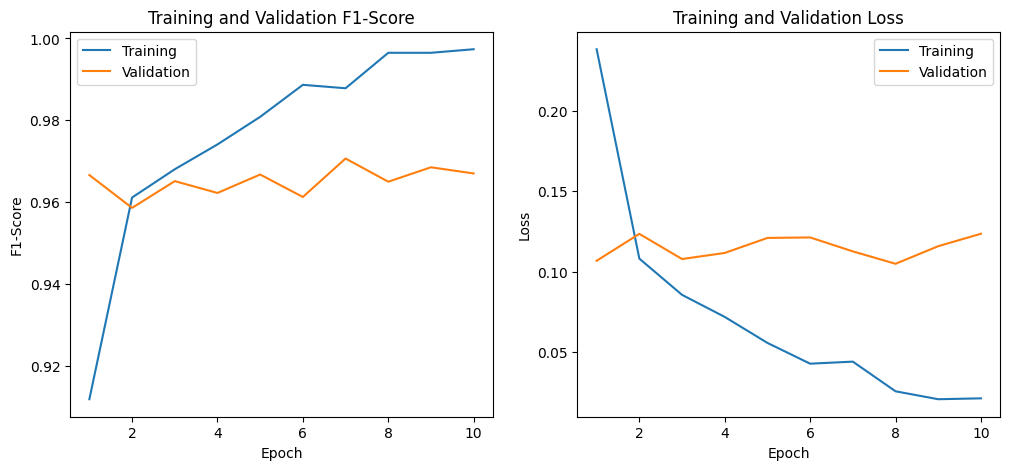

In [30]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1 = history.history["f1"]
val_f1 = history.history["val_f1"]

print(
    "Validation F1-Score:",
    val_f1[-1]
)


epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1, label="Training")
plt.plot(epoch_range, val_f1, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [31]:
Y_pred = model.predict(val_ds)

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 2ms/step


### Confusion matrix

In [32]:
Y_pred_labels = np.squeeze(np.round(Y_pred))
# Y_pred_classes=binary_mtx = tf.where(Y_pred >= 0.9, 1, 0).numpy()

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_labels, num_classes=2)
print(confusion_mtx.numpy())

[[227  13]
 [  4 249]]


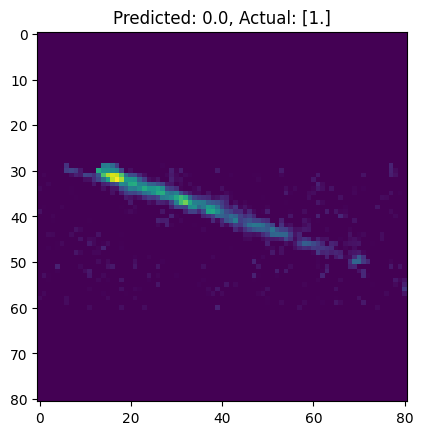

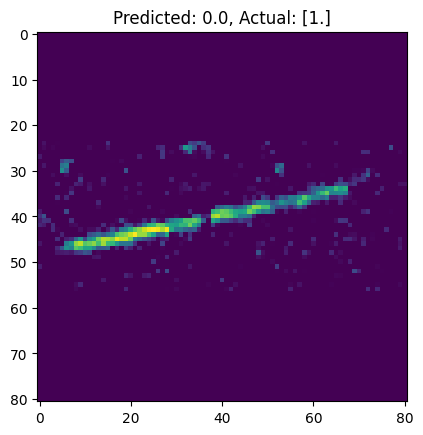

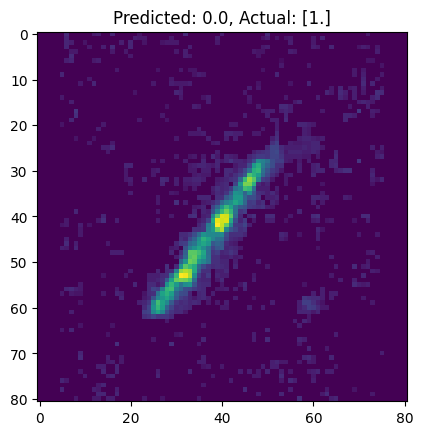

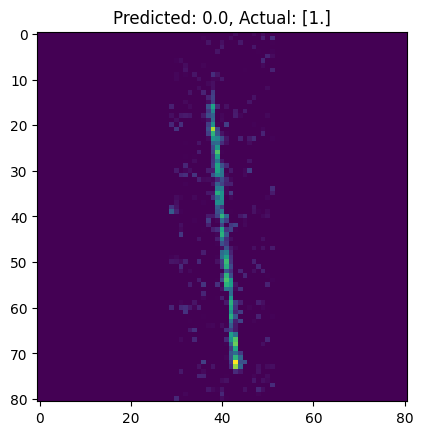

In [33]:
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:
        plt.imshow(img)
        plt.title(f"Predicted: {Y_pred_labels[i]}, Actual: {true_label}")
        plt.show()

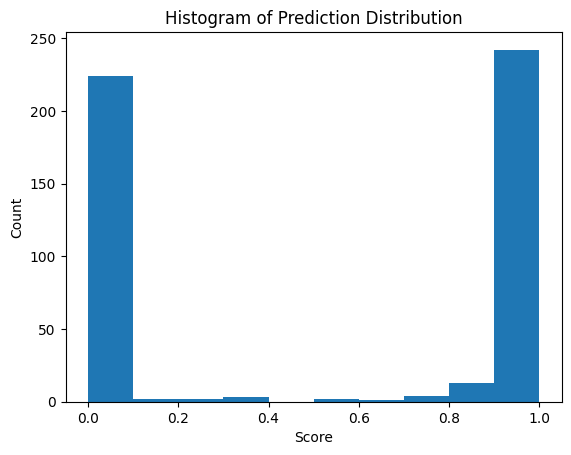

In [34]:
plt.hist(Y_pred, bins="auto")

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.show()

### Predicting single example

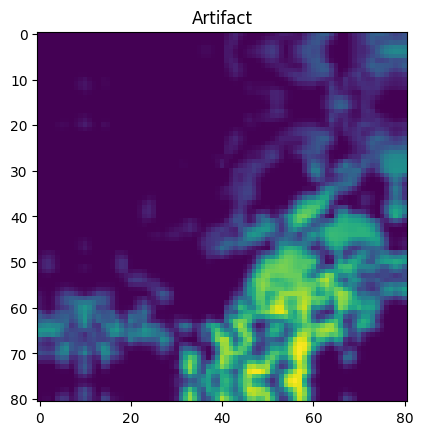

1/1 [==============================] - 0s 32ms/step
Prediction:           5.5350952266053355e-08 - > True


In [35]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

### Testing Fiachra's model


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Correct predictions: [201]
Test accuracy: [0.628125]


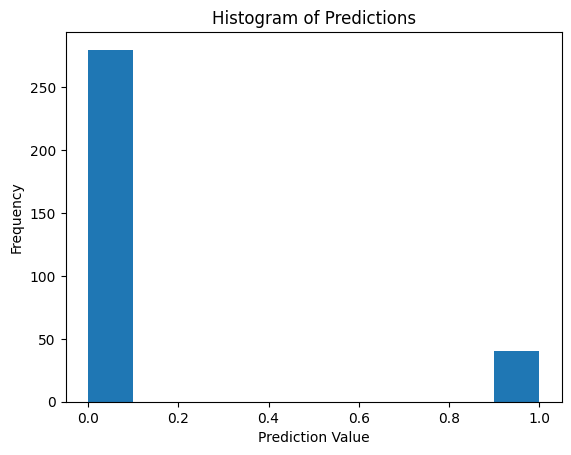

In [36]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
predictions=[]
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]
    # plt.figure()
    # img=resize_32(image_batch[0])
    # img=rescale(img)
    # img=image_batch[0]
    # print(img.numpy().max())
    # plt.imshow(img.numpy().astype("uint8"))
    # plt.title(f'{class_names[int(label_batch[0])]}')
    # plt.show()
    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        #print(output_data)
        #print(np.round(output_data)[0][0])
        
        prediction = int(np.round(output_data)[0][0])  # Get the highest scoring class
        #print(prediction)
        predictions.append(prediction)
        #break
        correct_predictions += prediction == label_batch[i].numpy()
        continue
        if i==image_batch.shape[0]-1:
                 
            plt.figure()
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f'{class_names[int(label_batch[i])]}')
            plt.show() 
            print(f"Prediction: {prediction} - > {class_names[prediction]} == {class_names[int(label_batch[i])]}")
        
        # break
    # break

print("Correct predictions:", correct_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)
plt.hist(predictions, bins='auto')
plt.title('Histogram of Predictions')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

Reason for such poor performance of the .tflite model is suspected to be because of drastic image resize to 32 px where important image features might be lost making image classification difficult.